In [1]:
# (CHECK) Generar imágenes con el mismo ruido, distinta label.

# Dado el label, determinar locations.

# Con yolo, generar las boxes para los locations.

# Generar máscara con los locations.

# Penalizar la diferencia fuera de las boxes. Visualizar.

In [1]:
import sys

sys.path.append('../')

In [2]:
import os
import torch

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test torch in GPU
x = torch.randn((1, 1)).to(device)
print(2 * x)

tensor([[-0.5974]], device='cuda:0')


In [3]:
from models.stylegan2_generator import StyleGAN2Generator

In [4]:
import torch

In [5]:
positives = torch.ones(10)
negatives = torch.zeros(10)
labels = torch.cat([negatives, positives], dim=0)
labels.shape

torch.Size([20])

In [6]:
codes = torch.randn((10, 512))
codes.shape

torch.Size([10, 512])

In [7]:
torch.cat([codes, codes], dim=0).shape

torch.Size([20, 512])

In [8]:
import torch
from jupyter_compare_view import compare
from PIL import Image, ImageDraw
from torchvision.transforms.functional import (
    to_pil_image,
    pil_to_tensor,
)
from tqdm import tqdm

Jupyter compare_view v0.2.1


In [9]:
import torch.nn.functional as F

In [10]:
F.one_hot(torch.randint(0, 2, (10,)))

tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]])

In [11]:
positives = torch.ones(10, dtype=torch.int64)
negatives = torch.zeros(10, dtype=torch.int64)
labels = torch.cat([negatives, positives], dim=0)
F.one_hot(labels, num_classes=2)


tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])

In [6]:
paths = {
    'stylegan2_imagenome256_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/stylegan2_imagenome256_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_device_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/c_stylegan2_imagenome256_device_pa_resized/checkpoints/best-fid50k_full-checkpoint-064000.pth',
    'c_stylegan2_imagenome256_lung_opacity_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/c_stylegan2_imagenome256_lung_opacity_pa_resized/checkpoints/best-fid50k_full-checkpoint-051200.pth',
    'c_stylegan2_imagenome256_atelectasis_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/c_stylegan2_imagenome256_atelectasis_pa_resized/checkpoints/best-fid50k_full-checkpoint-070400.pth',
    'c_stylegan2_imagenome256_enlarged_cardiac_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/c_stylegan2_imagenome256_enlarged_cardiac_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
    'c_stylegan2_imagenome256_pleural_effusion_pa_resized': '/home/gregschuit/projects/Hammer/Hammer/work_dirs/c_stylegan2_imagenome256_pleural_effusion_pa_resized/checkpoints/best-fid50k_full-checkpoint-075000.pth',
}


def load_generator(path):
    checkpoint = torch.load(path, map_location='cpu')
    init_kwargs = checkpoint['model_kwargs_init']['generator_smooth']
    del init_kwargs['model_type']
    model_kwargs_val = checkpoint['model_kwargs_val']['generator_smooth']
    model_kwargs_train = checkpoint['model_kwargs_train']
    generator = StyleGAN2Generator(**init_kwargs)
    generator.load_state_dict(checkpoint['models']['generator_smooth'])
    return generator, model_kwargs_val, model_kwargs_train


def process_generated_tensor(img_tensor: torch.Tensor) -> Image:
    """Converts a generated image tensor to a PIL image.

    The image tensor is expected to be approx. in the range [-1, 1], as is the case
    with the StyleGAN2Generator output.

    Args:
        img_tensor (torch.Tensor): The image tensor to convert.

    Returns:
        PIL.Image: The converted image.

    """
    _min, _max = -1, 1
    img_tensor = torch.clamp(img_tensor, _min, _max)
    img_tensor = (img_tensor - _min) / (_max - _min)
    pil_image = to_pil_image(img_tensor)
    return pil_image


def generate_images(generator, label, batch_size, model_kwargs, device='cpu'):
    """Uses the generator to generate a batch of images.

    Args:
        generator (StyleGAN2Generator): The generator to use.
        label (List[int]): The label to use in one-hot encoding. This list will be 
            repeated to match the batch size.
        batch_size (int): The number of images to generate.
        model_kwargs (dict): The model kwargs to be passed to the model on inference.

    """
    codes = torch.randn((batch_size, 512)).to(device)
    labels = torch.tensor([label] * batch_size).to(device)
    images = generator(codes, label=labels, **model_kwargs)['image']
    return images


def generate_images_with_same_noise(generator, batch_size, model_kwargs, device='cpu'):

    codes = torch.randn((batch_size, 512)).to(device)
    negative_labels = torch.tensor([[1, 0]] * batch_size).to(device)
    positive_labels = torch.tensor([[0, 1]] * batch_size).to(device)
    negative_images = generator(codes, label=negative_labels, **model_kwargs)['image']
    positive_images = generator(codes, label=positive_labels, **model_kwargs)['image']
    return negative_images, positive_images


def show_batch(batch_images):
    w, h = 256, 256
    cols, rows = 3, len(batch_images) // 3 + (len(batch_images) % 3 > 0)
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img_tensor in enumerate(batch_images):
        img = process_generated_tensor(img_tensor)
        grid.paste(img, box=(i % cols * w, i // cols * h))

    return grid


def show_slider(img1, img2):
    """Displays interactive visualization using jupyter-compare-view library.

    Images should be equal size and can be PIL Images.

    """
    return compare(img1, img2, add_controls=True, start_mode="vertical", start_slider_pos=0.73)



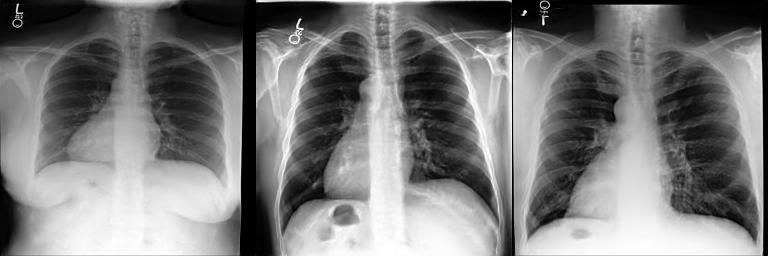
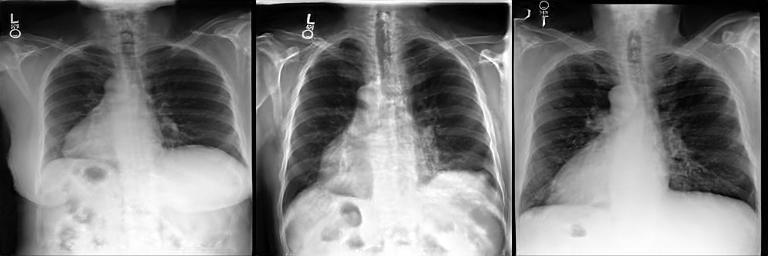

In [7]:
path = paths['c_stylegan2_imagenome256_atelectasis_pa_resized']
generator, model_kwargs, _ = load_generator(path)

batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs
)

show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

In [8]:
from ultralytics import YOLO

## Fine-tune generator using bounding boxes from yolo

In [9]:
def postprocess_batch(generated_images):
    _min, _max = -1, 1
    generated_images = torch.clamp(generated_images, _min, _max)
    generated_images = (generated_images - _min) / (_max - _min)
    return generated_images

def find_cardiac_box(result):
    try:
        return (result.boxes.cls == 2).nonzero()[0][0].item()
    except IndexError:
        return None

def get_box(result, idx):
    default_box = torch.tensor([30, 100, 226, 200])
    if idx is None:
        return default_box
    return result.boxes.xyxy[idx]

def get_mask(img, box):
    mask = torch.ones_like(pil_to_tensor(img))
    x1, y1, x2, y2 = box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    mask[:, y1:y2, x1:x2] = 0
    return mask

In [10]:
path = paths['c_stylegan2_imagenome256_enlarged_cardiac_pa_resized']
generator, model_kwargs_val, model_kwargs_train = load_generator(path)
yolo = YOLO('/home/gregschuit/projects/cxr-object-detection/runs/detect/train/weights/best.pt', task='detect')

In [11]:
generator.to(device)
yolo.to(device)

In [12]:
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)

In [13]:
STEPS = 10
BATCH_SIZE = 4

losses = []
skipped_steps = []

for step in range(STEPS):

    # Generate negative and positive images
    negative_images, positive_images = generate_images_with_same_noise(
        generator, BATCH_SIZE, model_kwargs_val, device=device
    )

    # Post process images
    negative_images = postprocess_batch(negative_images)
    positive_images = postprocess_batch(positive_images)

    # Generate bounding boxes for negative images using yolo
    with torch.no_grad():
        pil_imgs = [to_pil_image(img) for img in negative_images]
        results = yolo.predict(pil_imgs, verbose=False)

    cardiac_boxes_idxs = [find_cardiac_box(result) for result in results]

    # Filter batch ignoring when no box is found
    # batch_filter = torch.tensor([bool(x) for x in cardiac_boxes_idxs])
    # negative_images = negative_images[batch_filter]
    # positive_images = positive_images[batch_filter]

    # if all(batch_filter == False):
    #     skipped_steps.append(step)
    #     continue

    # filtered_results = []
    # filtered_cardiac_boxes_idxs = []
    # for i, keep in enumerate(batch_filter):
    #     if keep:
    #         filtered_results.append(results[i])
    #         filtered_cardiac_boxes_idxs.append(cardiac_boxes_idxs[i]) 
    # results = filtered_results
    # cardiac_boxes_idxs = filtered_cardiac_boxes_idxs

    cardiac_boxes = [
        get_box(result, idx) for result, idx in zip(results, cardiac_boxes_idxs)
    ]

    masks = [
        get_mask(
            img, box.cpu().tolist()
        ) for img, box in zip(pil_imgs, cardiac_boxes)
    ]
    mask = torch.cat(masks, axis=0).unsqueeze(1)
    mask = mask.to(device)

    # Substract images
    sqr_err = (negative_images - positive_images) ** 2
    masked_sqr_err = sqr_err * mask
    masked_mse = torch.sum(masked_sqr_err) / torch.sum(mask)

    # Backpropagate
    optimizer.zero_grad()
    masked_mse.backward()
    optimizer.step()

    if step % 5 == 0:
        print(f'Step {step}: {masked_mse.item()}')
        losses.append(masked_mse.item())


Step 0: 0.03730084002017975
Step 5: 0.023209530860185623


In [14]:
batch_size = 3
negative_images, positive_images = generate_images_with_same_noise(
    generator, batch_size, model_kwargs, device=device
)


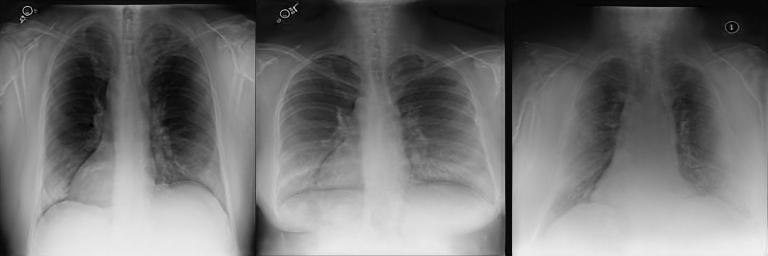
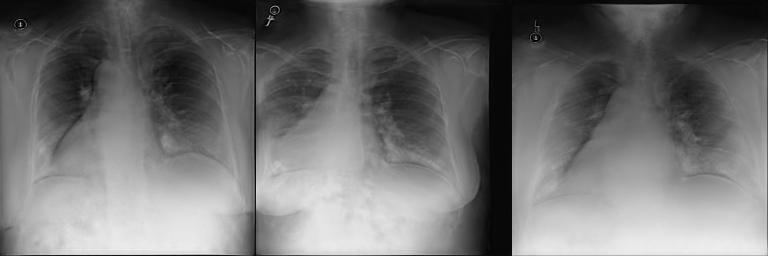

In [15]:
show_batch(torch.concat([negative_images, positive_images], axis=0))
show_slider(show_batch(negative_images), show_batch(positive_images))

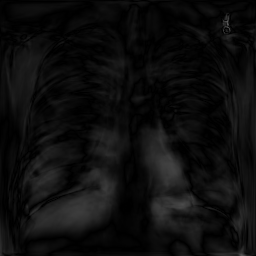

In [18]:
to_pil_image(torch.abs(negative_images - positive_images)[0])

In [18]:
def draw_bbox(img, x1, y1, x2, y2):
    img = img.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle((x1, y1, x2, y2))
    return img

def add_channels(img):
    return torch.cat([img] * 3, axis=1)

In [19]:
def process_generated_tensor(img_tensor: torch.Tensor) -> Image:
    """Converts a generated image tensor to a PIL image.

    The image tensor is expected to be approx. in the range [-1, 1], as is the case
    with the StyleGAN2Generator output.

    Args:
        img_tensor (torch.Tensor): The image tensor to convert.

    Returns:
        PIL.Image: The converted image.

    """
    _min, _max = -1, 1
    img_tensor = torch.clamp(img_tensor, _min, _max)
    img_tensor = (img_tensor - _min) / (_max - _min)
    pil_image = to_pil_image(img_tensor)
    return pil_image


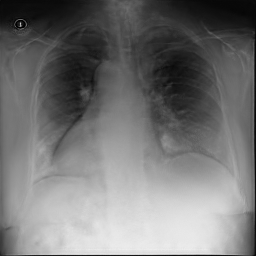

In [20]:
img = process_generated_tensor(positive_images[0])
img

In [21]:
results = yolo.predict([img])

In [22]:
results[0].boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[134.1584,  16.8140, 232.8568, 180.6222,   0.9565,  28.0000],
        [133.6646,  22.7620, 216.7380,  87.8199,   0.9555,  31.0000],
        [123.2599, 156.0865, 232.5318, 254.7404,   0.9524,  30.0000],
        [ 33.3591, 155.8721, 232.8511, 254.7241,   0.9515,   0.0000],
        [ 39.1211,  23.7771, 119.2803,  87.8115,   0.9436,  17.0000],
        [ 33.1975,  18.0103, 119.9526, 191.3736,   0.9429,  14.0000],
        [142.7174, 121.1171, 232.8904, 180.3858,   0.9267,  27.0000],
        [139.8986,  87.9690, 222.6805, 121.1664,   0.9226,  29.0000],
        [ 45.0982,  18.6452, 119.0878,  60.9941,   0.9130,   6.0000],
        [133.8825,  16.8791, 208.6052,  60.9086,   0.9044,  19.0000],
        [ 36.4266,  87.7684, 117.1887, 125.6171,   0.9022,  15.0000],
        [137.2804,  80.4961, 181.3339, 127.4221,   0.8987,  26.0000],
        [ 32.7433, 125.6294, 114.5843, 190.9792,   0.8968,  13.0000],
        [ 32.7902, 1

In [23]:
result = results[0]

In [24]:
result.names

{0: 'abdomen',
 1: 'aortic arch',
 2: 'cardiac silhouette',
 3: 'carina',
 4: 'cavoatrial junction',
 5: 'descending aorta',
 6: 'left apical zone',
 7: 'left cardiac silhouette',
 8: 'left cardiophrenic angle',
 9: 'left clavicle',
 10: 'left costophrenic angle',
 11: 'left hemidiaphragm',
 12: 'left hilar structures',
 13: 'left lower lung zone',
 14: 'left lung',
 15: 'left mid lung zone',
 16: 'left upper abdomen',
 17: 'left upper lung zone',
 18: 'mediastinum',
 19: 'right apical zone',
 20: 'right atrium',
 21: 'right cardiac silhouette',
 22: 'right cardiophrenic angle',
 23: 'right clavicle',
 24: 'right costophrenic angle',
 25: 'right hemidiaphragm',
 26: 'right hilar structures',
 27: 'right lower lung zone',
 28: 'right lung',
 29: 'right mid lung zone',
 30: 'right upper abdomen',
 31: 'right upper lung zone',
 32: 'spine',
 33: 'svc',
 34: 'trachea',
 35: 'upper mediastinum'}

right lung


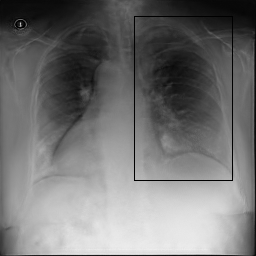

In [25]:
box_idx = 0
name = result.names[result.boxes.cls[box_idx].item()]
box = result.boxes.xyxy[box_idx]

print(name)
draw_bbox(img, *box)

In [116]:
def postprocess_batch(generated_images):
    _min, _max = -1, 1
    generated_images = torch.clamp(generated_images, _min, _max)
    generated_images = (generated_images - _min) / (_max - _min)
    return generated_images

In [87]:
yolo.predict(postprocess_batch(negative_images[0]))[0].boxes


0: 256x256 1 abdomen, 1 aortic arch, 1 cardiac silhouette, 1 carina, 1 cavoatrial junction, 1 descending aorta, 1 left apical zone, 1 left cardiac silhouette, 1 left cardiophrenic angle, 1 left clavicle, 1 left costophrenic angle, 1 left hemidiaphragm, 1 left hilar structures, 1 left lower lung zone, 1 left lung, 1 left mid lung zone, 1 left upper abdomen, 1 left upper lung zone, 1 mediastinum, 1 right apical zone, 1 right atrium, 1 right cardiac silhouette, 1 right cardiophrenic angle, 1 right clavicle, 1 right costophrenic angle, 1 right hemidiaphragm, 1 right hilar structures, 1 right lower lung zone, 1 right lung, 1 right mid lung zone, 1 right upper abdomen, 1 right upper lung zone, 1 spine, 1 svc, 1 trachea, 1 upper mediastinum, 31.2ms
Speed: 16.2ms preprocess, 31.2ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)
WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[ 44.5489,  26.7148, 126.4188, 214.9234,   0.9717,  28.0000],
        [ 43.9042, 177.2220, 223.4724, 248.7501,   0.9706,   0.0000],
        [142.1618,  28.3217, 223.4990, 219.6708,   0.9648,  14.0000],
        [142.2905,  33.6940, 218.6579,  95.8685,   0.9620,  17.0000],
        [ 52.9205,  32.2921, 126.2579,  96.2694,   0.9610,  31.0000],
        [109.4931,  53.1469, 191.4664, 197.8498,   0.9558,  18.0000],
        [141.8606, 188.6199, 223.4824, 219.7415,   0.9512,  11.0000],
        [ 59.6762,  27.0230, 126.2779,  68.7147,   0.9480,  19.0000],
        [138.2407, 194.2871, 223.4175, 246.9662,   0.9474,  16.0000],
        [ 44.4013, 176.9655, 138.2312, 247.1163,   0.9452,  30.0000],
        [ 44.4816, 139.3158, 118.8306, 214.8919,   0.9448,  27.0000],
        [ 44.4868, 171.5594, 133.4182, 214.8062,   0.9435,  25.0000],
        [109.7301, 124.5875, 191.3088, 198.0593,   0.9428,   2.0000],
        [144.1868, 1

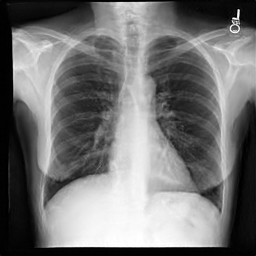

In [88]:
processed = postprocess_batch(negative_images[0])
processed

In [90]:
_ = yolo.predict(processed)  # It works if I use a PIL image


0: 256x256 1 abdomen, 1 aortic arch, 1 cardiac silhouette, 1 carina, 1 cavoatrial junction, 1 descending aorta, 1 left apical zone, 1 left cardiac silhouette, 1 left cardiophrenic angle, 1 left clavicle, 1 left costophrenic angle, 1 left hemidiaphragm, 1 left hilar structures, 1 left lower lung zone, 1 left lung, 1 left mid lung zone, 1 left upper abdomen, 1 left upper lung zone, 1 mediastinum, 1 right apical zone, 1 right atrium, 1 right cardiac silhouette, 1 right cardiophrenic angle, 1 right clavicle, 1 right costophrenic angle, 1 right hemidiaphragm, 1 right hilar structures, 1 right lower lung zone, 1 right lung, 1 right mid lung zone, 1 right upper abdomen, 1 right upper lung zone, 1 spine, 1 svc, 1 trachea, 1 upper mediastinum, 12.7ms
Speed: 16.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 256)


In [100]:
pil_to_tensor(processed).unsqueeze(0).shape

torch.Size([1, 1, 256, 256])

In [103]:
add_channels(pil_to_tensor(processed).unsqueeze(0)).shape

torch.Size([1, 3, 256, 256])

In [104]:
_ = yolo.predict(add_channels(pil_to_tensor(processed).unsqueeze(0)))  # It doesn't work if I use a tensor


28.6ms


In [109]:
pil_to_tensor(processed.convert('RGB')).shape  # Let's try converting to RGB before converting to tensor

torch.Size([3, 256, 256])

In [110]:
_ = yolo.predict(pil_to_tensor(processed.convert('RGB')).unsqueeze(0))  # It doesn't work if I use a tensor


38.3ms


In [117]:
imgs = [to_pil_image(img) for img in postprocess_batch(negative_images)]

In [133]:
results = yolo.predict(imgs)

def find_cardiac_box(result):
    try:
        return (result.boxes.cls == 2).nonzero()[0][0].item()
    except IndexError:
        return None

cardiac_boxes_idxs = [find_cardiac_box(result) for result in results]
cardiac_boxes_idxs


0: 256x256 1 abdomen, 1 aortic arch, 1 cardiac silhouette, 1 carina, 1 cavoatrial junction, 1 descending aorta, 1 left apical zone, 1 left cardiac silhouette, 1 left cardiophrenic angle, 1 left clavicle, 1 left costophrenic angle, 1 left hemidiaphragm, 1 left hilar structures, 1 left lower lung zone, 1 left lung, 1 left mid lung zone, 1 left upper abdomen, 1 left upper lung zone, 1 mediastinum, 1 right apical zone, 1 right atrium, 1 right cardiac silhouette, 1 right cardiophrenic angle, 1 right clavicle, 1 right costophrenic angle, 1 right hemidiaphragm, 1 right hilar structures, 1 right lower lung zone, 1 right lung, 1 right mid lung zone, 1 right upper abdomen, 1 right upper lung zone, 1 spine, 1 svc, 1 trachea, 1 upper mediastinum, 1: 256x256 1 abdomen, 1 aortic arch, 1 cardiac silhouette, 1 carina, 1 cavoatrial junction, 1 descending aorta, 1 left apical zone, 1 left cardiac silhouette, 1 left cardiophrenic angle, 1 left clavicle, 1 left hemidiaphragm, 1 left hilar structures, 1 l

[12, 21, 15]

In [134]:
def get_box(result, idx):
    if idx is None:
        return None
    return result.boxes.xyxy[idx]

cardiac_boxes = [get_box(result, idx) for result, idx in zip(results, cardiac_boxes_idxs)]
cardiac_boxes

[tensor([109.7301, 124.5875, 191.3088, 198.0593], device='cuda:0'),
 tensor([ 36.2769, 105.0500, 140.6139, 179.7489], device='cuda:0'),
 tensor([ 57.7643, 120.3373, 142.7956, 186.7221], device='cuda:0')]

In [138]:
cardiac_boxes[0].cpu().tolist()

[109.73014831542969,
 124.58746337890625,
 191.30882263183594,
 198.05929565429688]

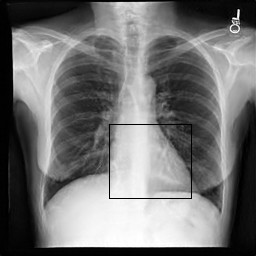

In [140]:
draw_bbox(imgs[0], *cardiac_boxes[0].cpu().tolist())

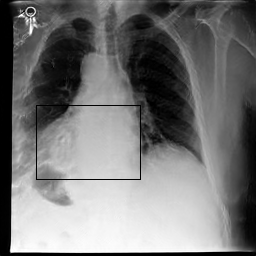

In [141]:
draw_bbox(imgs[1], *cardiac_boxes[1].cpu().tolist())

In [142]:
# Take the boxes of the negative images (or positive)

cardiac_boxes

[tensor([109.7301, 124.5875, 191.3088, 198.0593], device='cuda:0'),
 tensor([ 36.2769, 105.0500, 140.6139, 179.7489], device='cuda:0'),
 tensor([ 57.7643, 120.3373, 142.7956, 186.7221], device='cuda:0')]

In [154]:
# Construct the masks

def get_mask(img, box):
    mask = torch.ones_like(pil_to_tensor(img))
    x1, y1, x2, y2 = box
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    mask[:, y1:y2, x1:x2] = 0

    return mask

masks = [get_mask(img, box.cpu().tolist()) for img, box in zip(imgs, cardiac_boxes)]
masks

[tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8),
 tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8),
 tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]], dtype=torch.uint8)]

In [166]:
mask = torch.cat(masks, axis=0).unsqueeze(1)
mask.shape

torch.Size([3, 1, 256, 256])

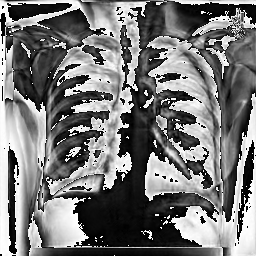

In [170]:
# Substract and apply mask

difference = negative_images - positive_images
to_pil_image(difference[0])

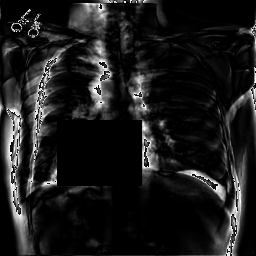

In [174]:
masked_squared_error = (difference * mask) ** 2
to_pil_image(masked_squared_error[2])

In [172]:
masked_mse = torch.sum(masked_squared_error) / torch.sum(mask)
masked_mse

tensor(0.1762, grad_fn=<DivBackward0>)